# Import everything

In [14]:
import glob
import pandas as pd
import mne
import matplotlib.pyplot as plt
from io import StringIO
import mne
from mne.io import read_raw_eeglab, read_epochs_eeglab
import numpy as np
from scipy import signal
from scipy import fftpack
import seaborn as sns
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
# from tqdm import tqdm, tqdm_notebook
from tqdm.notebook import tqdm
import math
from sklearn import preprocessing
from sklearn.linear_model import SGDClassifier
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor
from sklearn.svm import SVR
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from keras_tqdm import TQDMNotebookCallback
from tensorboard.plugins.hparams import api as hp
from livelossplot.tf_keras import PlotLossesCallback

import sklearn.model_selection
import sklearn.datasets
import sklearn.metrics
import multiprocessing
from tpot import TPOTRegressor
from oct2py import octave
from joblib import Parallel, delayed
import multiprocessing
from joblib import wrap_non_picklable_objects
import json
import pickle
import os.path
from mpl_toolkits.mplot3d import axes3d
import timeit
from skimage.transform import resize
from timeit import default_timer as timer
from datetime import timedelta
import json
import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.genmod import bayes_mixed_glm as glm
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
from sklearn.feature_selection import RFECV
from spectrum import arburg, arma2psd, pburg
import pylab
from scipy.signal import find_peaks, butter
from scipy.integrate import simps
from scipy.io import loadmat
from numpy import trapz
import gzip
import scipy.fftpack

# Power and phase calculations

In [15]:
def blackman_harris_filter(channel, time, cutoffs, fs, numtaps):
    b = signal.firwin(numtaps, cutoffs, window='blackmanharris', fs=fs)
    filtered = signal.lfilter(b, 1, channel)
    delay = 0.5 * (numtaps - 1) / fs
    df = pd.DataFrame({
        'time': time-delay,
        'channel': filtered
    })
    return df

def butter_bandpass_filter(data, lowcut, highcut, fs, btype, order):
    nyq = 0.5 * fs
    low = lowcut / nyq
    high = highcut / nyq
    b, a = butter(order, [low, high], btype=btype)
    y = signal.lfilter(b, a, data)
    return y

def get_phase(channel, time, band, fs, filter_type, start_time_ms, stop_time_ms, blackmann_harris_ntaps):
    if filter_type=='butter':
        df_filtered = pd.DataFrame({'channel': butter_bandpass_filter(channel, band[0], band[1], fs, btype='bandpass', order=3), 'time': time})
    else:
        df_filtered = blackman_harris_filter(channel, time, [0.000001, band[0]], fs, numtaps=blackmann_harris_ntaps)
        df_filtered = blackman_harris_filter(df_filtered['channel'].values, df_filtered['time'].values, band[1], fs, numtaps=blackmann_harris_ntaps)    
    
    hilb = signal.hilbert(df_filtered[(df_filtered['time'] > start_time_ms) & (df_filtered['time'] < stop_time_ms)]['channel'])
    phase = np.angle(hilb, deg=True)
    df_phase = pd.DataFrame(phase, columns=['phase'])
    df_phase['time'] = df_filtered[(df_filtered['time'] > start_time_ms) & (df_filtered['time'] < stop_time_ms)]['time'].values
    return df_phase

def get_power(channel, time, fs, crop_start_millis, crop_end_millis, method, filter_type, resample_fs, line_noise_band, blackmann_harris_ntaps):
    # Crop.
    channel = channel[(time > crop_start_millis) & (time < crop_end_millis)].values
    time = time[(time > crop_start_millis) & (time < crop_end_millis)].values
    
    # Resample
    if resample_fs is None:
        resampled = channel
        resampled_time = time
    else:
        ts = time[1] - time[0]
        secs = len(channel) * ts
        secs = secs/1000
        resampled = signal.resample(channel, int(secs*resample_fs))
        resampled_time = np.linspace(time[0], time[-1], len(resampled))
        fs = resample_fs

    # Remove line nosie.
    if filter_type == 'butter':
        resampled = butter_bandpass_filter(resampled, line_noise_band[0], line_noise_band[1], fs, 'bandstop', order=4)
        resampled_time = time
    else:
        df_filtered = blackman_harris_filter(resampled, resampled_time, line_noise_band, fs, numtaps=blackmann_harris_ntaps)
        resampled = df_filtered['channel']
        resampled_time = df_filtered['time']
    
    # PSD.
    if method == 'welch':
        # Welch method
        freq, power = signal.welch(resampled, fs, nperseg=4*fs, nfft=fs)
        df_power = pd.DataFrame({'freq': freq, 'power': power})
    elif method == 'fft':
        # FFT method
        T = 1/fs
        N = fs//2
        yf = scipy.fftpack.fft(resampled, n=N)
        yf = 2 / (N/2) * np.abs(yf[:N//2])
        xf = np.linspace(0, 1/(2*T), N // 2)
        df_power = pd.DataFrame({'freq': xf, 'power': yf})
    elif method == 'pburg':
        # Burgs method
        order = min(len(resampled)-2, int(fs/4))
        p = pburg(resampled, order, sampling=fs, NFFT=fs)
        power = p.psd
        freq = np.linspace(0, fs/2, len(power))
        df_power = pd.DataFrame({'freq': freq, 'power': power})

    df_power = df_power[df_power['freq'] < fs/2]
    df_power['power'] = 10 * np.log10(df_power['power'])
    return df_power

In [16]:
# Read hjorth file.
def get_hjorth_path(path):
    return path.replace('.csv', '-hjorth.mat')

def get_hjorth_trial(filename):
    x = loadmat(filename)
    c3 = x['dat'][0][0][3][0][0][0]
    trials = []
    time = np.linspace(0, 1000, len(c3))
    return pd.DataFrame({'C3': c3, 'time': time})

In [17]:
raw_files = sorted(glob.glob('data/dataset2/alcoholism-02-for-matlab/*/*.csv'))
hjorth_files = list(map(get_hjorth_path, raw_files))

# Diagnose

20 - data/dataset2/alcoholism-02-for-matlab/co2a0000364/trial-15.csv


/home/raquib/anaconda3/envs/tmseeg/lib/python3.7/site-packages/scipy/signal/spectral.py:1969: UserWarning: nperseg = 1024 is greater than input length  = 38, using nperseg = 38
  .format(nperseg, input_length))


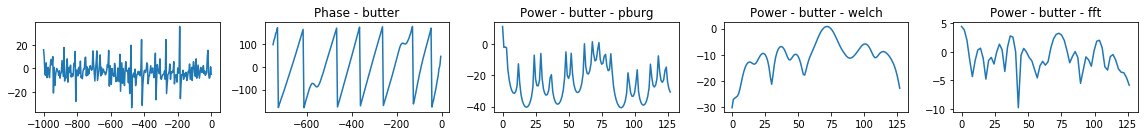

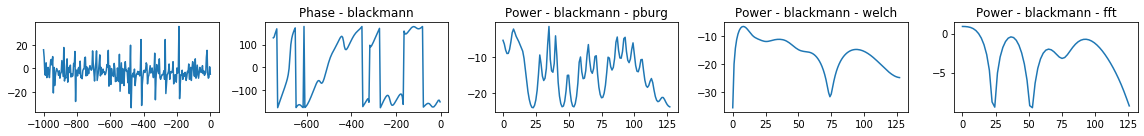

In [18]:
ind = 20
print("{} - {}".format(ind, raw_files[ind]))
df_trial = pd.read_csv(raw_files[ind])
df_trial_hjorth = get_hjorth_trial(hjorth_files[ind])
channel = df_trial['C3']
time = df_trial_hjorth['time'] - 1000

fs = 256
band = [8, 12]
blackmann_harris_ntaps = 51
line_noise_band = [48, 52]
time_start = -150

for filter_type in ['butter', 'blackmann']:
    i = 0
    f, axs = plt.subplots(1,5,figsize=(16,2))
    axs[i].plot(time, channel)
    i = i + 1

    df_phase = get_phase(channel, time, band=band, fs=fs, filter_type=filter_type, start_time_ms=-750, stop_time_ms=-1, blackmann_harris_ntaps=blackmann_harris_ntaps)
    axs[i].plot(df_phase['time'], df_phase['phase'])
    axs[i].set_title("Phase - {}".format(filter_type))
    i = i + 1

    for method in ['pburg', 'welch', 'fft']:
        df_power = get_power(channel, time, fs, crop_start_millis=time_start, crop_end_millis=-1, method=method, filter_type=filter_type, resample_fs=None, line_noise_band=line_noise_band, blackmann_harris_ntaps=blackmann_harris_ntaps)
        df_power = df_power[df_power['freq'] < 130]
        axs[i].plot(df_power['freq'], df_power['power'])
        axs[i].set_title("Power - {} - {}".format(filter_type, method))
        i = i + 1
    plt.tight_layout()
    plt.show()

# Process trials

In [6]:
def process_trial(raw_path, hjorth_path):
    df_powers = []
    df_phases = []
    subject = raw_path.split('/')[3]
    df_trial_raw = pd.read_csv(raw_path)
    df_trial_hjorth = get_hjorth_trial(hjorth_path)
    df_trial_hjorth['time'] = df_trial_hjorth['time'] - 1000
    df_trial_avg = df_trial_raw.copy()
    df_trial_avg['C3'] = df_trial_avg[['C3', 'FC6', 'FC4', 'FC2', 'C6', 'C4', 'C2', 'CP6', 'CP4', 'CP2']].mean(axis=1)
    df_trial_raw['time'] = df_trial_hjorth['time']
    df_trial_avg['time'] = df_trial_hjorth['time']
    
    trial_num = int(raw_path.split('/')[4].split('-')[1].split('.')[0])
    df_sub = pd.read_csv('data/dataset2/alcoholism-01-parsed/' + subject + '.csv')
    power_row = {
        'sub': subject,
        'trial': trial_num,
        'alcoholic': df_sub.iloc[0]['alcoholic'],
        'condition': df_sub[df_sub['trial'] == trial_num].iloc[0]['condition']
    }
    
    for eeg_type, df_trial in zip(['Raw', 'Hjorth', 'Averaged'], [df_trial_raw, df_trial_hjorth, df_trial_avg]):
        for filter_code, filter_name in zip(['butter', 'blackmannharris'], ['Butterworth', 'Blackmann-Harris']):
            for time, ntaps in zip([-750, -150], [101, 51]):
                for method_code, method_name in zip(['pburg', 'welch', 'fft'], ['Burg', 'Welch', 'FFT']):

                    try:
                        df_power = get_power(df_trial['C3'], df_trial['time'], fs=256, crop_start_millis=time, crop_end_millis=-1, method=method_code, filter_type=filter_code, resample_fs=None, line_noise_band=[48, 52], blackmann_harris_ntaps=ntaps)
                    except:
                        continue

                    for band, fc1, fc2 in zip(['Theta', 'Mu', 'Beta', 'Gamma'], [3.5, 8, 13, 30], [8, 12, 30, 80]):
                        power = df_power[df_power['freq'] >= fc1]
                        power = power[power['freq'] < fc2]
                        power = power['power'].mean(axis=0)
                        row = power_row.copy()
                        row['EEG'] = eeg_type
                        row['Filter'] = filter_name
                        row['Time'] = time
                        row['Method'] = method_name
                        row['Band'] = band
                        row['Power'] = power
                        df_powers.append(row)
            for band, fc1, fc2 in zip(['Theta', 'Mu', 'Beta', 'Gamma'], [3.5, 8, 13, 30], [8, 12, 30, 80]):
                phase = get_phase(df_trial['C3'], df_trial['time'], [fc1, fc2], filter_type=filter_code, start_time_ms=-750, stop_time_ms=-1, fs=256, blackmann_harris_ntaps=101)
                phase = phase.iloc[-1]['phase'] + 180
                row = power_row.copy()
                row['EEG'] = eeg_type
                row['Filter'] = filter_name
                row['Band'] = band
                row['Phase'] = phase
                df_phases.append(row)
    return (df_powers, df_phases)

In [7]:
# Run analysis
num_cores = multiprocessing.cpu_count() - 2
results = Parallel(n_jobs=num_cores)(delayed(process_trial)(path_raw, path_hjorth) for path_raw, path_hjorth in tqdm(zip(raw_files, hjorth_files), total=len(raw_files)))

In [8]:
df_power = []
df_phase = []
for powers, phases in results:
    for row in powers:
        df_power.append(row)
    for row in phases:    
        df_phase.append(row)
df_power = pd.DataFrame(df_power)
df_phase = pd.DataFrame(df_phase)
df_power.head()

,Band,EEG,Filter,Method,Power,Time,alcoholic,condition,sub,trial
0,Theta,Raw,Butterworth,Burg,-7.036983,-750,True,S1 obj,co2a0000364,0
1,Mu,Raw,Butterworth,Burg,-6.576644,-750,True,S1 obj,co2a0000364,0
2,Beta,Raw,Butterworth,Burg,-3.448964,-750,True,S1 obj,co2a0000364,0
3,Gamma,Raw,Butterworth,Burg,-4.178361,-750,True,S1 obj,co2a0000364,0
4,Theta,Raw,Butterworth,Welch,-11.012937,-750,True,S1 obj,co2a0000364,0


In [9]:
def_values_power = {
    'EEG': 'Raw', 
    'Filter': 'Butterworth', 
    'Time': -750, 
    'Method': 'Welch'
}
def_values_phase = {
    'EEG': 'Raw',
    'Filter': 'Butterworth', 
}

In [ ]:
df_power_new = []
keys = list(def_values_power.keys())
for sub in tqdm(df_power['sub'].unique()):
    df_sub = df_power[df_power['sub'] == sub]
    for val1 in df_power[keys[0]].unique():
        for val2 in df_power[keys[1]].unique():
            for val3 in df_power[keys[2]].unique():
                for val4 in df_power[keys[3]].unique():
                    for val5 in df_power['Band'].unique():
                        df_power2 = df_sub[df_sub['Band'] == val5]
                        df_power2 = df_power2[df_power2[keys[3]] == val4]
                        df_power2 = df_power2[df_power2[keys[2]] == val3]
                        df_power2 = df_power2[df_power2[keys[1]] == val2]
                        df_power2 = df_power2[df_power2[keys[0]] == val1]
                        i = 1
                        for idx, row in df_power2.iterrows():
                            row['trial_abs'] = i
                            df_power_new.append(row)
                            i = i + 1
df_power_new = pd.DataFrame(df_power_new)

In [ ]:
df_phase_new = []
keys = list(def_values_phase.keys())
for sub in tqdm(df_phase['sub'].unique()):
    df_sub = df_phase[df_phase['sub'] == sub]
    for val1 in df_phase[keys[0]].unique():
        for val2 in df_phase[keys[1]].unique():
            for val3 in df_phase['Band'].unique():
                df_phase2 = df_sub[df_sub[keys[0]] == val1]
                df_phase2 = df_phase2[df_phase2[keys[1]] == val2]
                df_phase2 = df_phase2[df_phase2['Band'] == val3]
                i = 1
                for idx, row in df_phase2.iterrows():
                    row['trial_abs'] = i
                    df_phase_new.append(row)
                    i = i + 1
df_phase_new = pd.DataFrame(df_phase_new)

In [ ]:
df_power_new.to_csv('157-d2-power.csv')
df_phase_new.to_csv('157-d2-phase.csv')